# Fitting exp(kα² + bα + c) to Variance Data

**Date:** October 29, 2025

**Goal:** Quantify the exponential-quadratic relationship between steering magnitude and inter-layer variance.

**Model:**
```
variance(α) = A · exp(k·α² + b·α + c)
```

**Parameters:**
- **k**: Curvature parameter (the key parameter - measures manifold geometry)
- **b**: Asymmetry parameter (measures shift of KALM region)
- **c**: Baseline parameter (offset)
- **A**: Amplitude (absorbed into c in log space)

**Hypotheses:**
- **Jeffery:** R² mediocre (~0.7) due to noisy grade levels, but p-values tiny (< 0.001) due to strong structural signal
- **Alpha:** R² in log space better (~0.9), k will be highly significant (p < 10⁻¹⁰), b small but nonzero

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
from sklearn.metrics import r2_score

# Configuration
DATA_PATH = '../data/results/multiband_scan_sun.csv'

print("Loading sun scan data...")
df = pd.read_csv(DATA_PATH)
print(f"✓ Loaded {len(df):,} rows")

Loading sun scan data...
✓ Loaded 18,000 rows


## Compute Variance

In [2]:
# Compute variance across layers at each alpha
variance = df.groupby('alpha')['grade_level'].var().reset_index()
variance.columns = ['alpha', 'variance']

# Remove any NaN or inf values
variance = variance[np.isfinite(variance['variance']) & (variance['variance'] > 0)]

alpha = variance['alpha'].values
var = variance['variance'].values

print(f"Variance data: {len(variance)} points")
print(f"  Alpha range: [{alpha.min():.2f}, {alpha.max():.2f}]")
print(f"  Variance range: [{var.min():.2f}, {var.max():.2f}]")

Variance data: 500 points
  Alpha range: [-10.00, 10.00]
  Variance range: [0.02, 4679.14]


## Method 1: Nonlinear Fit (Original Space)

Fit `variance(α) = A · exp(k·α² + b·α + c)` directly using `curve_fit`.

In [3]:
# Define model
def exp_quadratic(alpha, A, k, b, c):
    return A * np.exp(k * alpha**2 + b * alpha + c)

# Initial guess
p0 = [var.mean(), 0.01, 0.0, 0.0]

# Fit
try:
    params, covariance = curve_fit(exp_quadratic, alpha, var, p0=p0, maxfev=10000)
    A_fit, k_fit, b_fit, c_fit = params
    
    # Compute standard errors
    perr = np.sqrt(np.diag(covariance))
    A_err, k_err, b_err, c_err = perr
    
    # Predictions
    var_pred = exp_quadratic(alpha, *params)
    
    # R² in linear space
    r2_linear = r2_score(var, var_pred)
    
    # Residuals
    residuals = var - var_pred
    
    print("\n" + "="*60)
    print("METHOD 1: Nonlinear Fit (Original Space)")
    print("="*60)
    print(f"\nFitted parameters:")
    print(f"  A = {A_fit:.4f} ± {A_err:.4f}")
    print(f"  k = {k_fit:.6f} ± {k_err:.6f}  ← CURVATURE PARAMETER")
    print(f"  b = {b_fit:.6f} ± {b_err:.6f}  ← ASYMMETRY")
    print(f"  c = {c_fit:.6f} ± {c_err:.6f}")
    print(f"\nGoodness of fit:")
    print(f"  R² (linear space) = {r2_linear:.4f}")
    print(f"  RMSE = {np.sqrt(np.mean(residuals**2)):.2f}")
    
    fit_success_nonlinear = True
    
except Exception as e:
    print(f"\nNonlinear fit failed: {e}")
    fit_success_nonlinear = False


METHOD 1: Nonlinear Fit (Original Space)

Fitted parameters:
  A = 595.6297 ± 3272397434.6098
  k = 0.028149 ± 0.001332  ← CURVATURE PARAMETER
  b = 0.034278 ± 0.003461  ← ASYMMETRY
  c = -1.959050 ± 5504830.850855

Goodness of fit:
  R² (linear space) = 0.6513
  RMSE = 280.43


## Method 2: Linear Fit (Log Space)

Transform to log space and fit as polynomial: `log(variance) = k·α² + b·α + (c + log(A))`

In [4]:
# Transform to log space
log_var = np.log(var)

# Design matrix: [α², α, 1]
X = np.column_stack([alpha**2, alpha, np.ones_like(alpha)])

# Fit using least squares
from numpy.linalg import lstsq
coeffs, residuals_sum, rank, singular_values = lstsq(X, log_var, rcond=None)

k_log, b_log, c_plus_logA = coeffs

# Predictions in log space
log_var_pred = X @ coeffs

# R² in log space
r2_log = r2_score(log_var, log_var_pred)

# Back-transform to linear space
var_pred_log = np.exp(log_var_pred)
r2_linear_from_log = r2_score(var, var_pred_log)

# Compute standard errors using residual variance
residuals_log = log_var - log_var_pred
residual_var = np.var(residuals_log, ddof=3)  # 3 parameters
cov_matrix = residual_var * np.linalg.inv(X.T @ X)
se = np.sqrt(np.diag(cov_matrix))
k_log_err, b_log_err, c_log_err = se

# Compute t-statistics and p-values
t_stats = coeffs / se
p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), df=len(alpha)-3))

print("\n" + "="*60)
print("METHOD 2: Linear Fit (Log Space)")
print("="*60)
print(f"\nFitted parameters:")
print(f"  k = {k_log:.6f} ± {k_log_err:.6f}  ← CURVATURE")
print(f"      t = {t_stats[0]:.2f}, p < {p_values[0]:.2e}")
print(f"  b = {b_log:.6f} ± {b_log_err:.6f}  ← ASYMMETRY")
print(f"      t = {t_stats[1]:.2f}, p < {p_values[1]:.2e}")
print(f"  c+log(A) = {c_plus_logA:.6f} ± {c_log_err:.6f}")
print(f"      t = {t_stats[2]:.2f}, p < {p_values[2]:.2e}")
print(f"\nGoodness of fit:")
print(f"  R² (log space) = {r2_log:.4f}")
print(f"  R² (back-transformed to linear) = {r2_linear_from_log:.4f}")
print(f"  RMSE (log space) = {np.sqrt(np.mean(residuals_log**2)):.4f}")

print("\n" + "="*60)
print("HYPOTHESIS TEST RESULTS")
print("="*60)
if p_values[0] < 0.001:
    print(f"✓ Quadratic term (k) is HIGHLY SIGNIFICANT (p < {p_values[0]:.2e})")
    print(f"  → exp(α²) relationship CONFIRMED")
else:
    print(f"✗ Quadratic term not significant (p = {p_values[0]:.4f})")

if abs(b_log) > 0.001 and p_values[1] < 0.05:
    print(f"\n✓ Linear term (b) is significant (p < {p_values[1]:.2e})")
    print(f"  → KALM region is asymmetric")
else:
    print(f"\n→ Linear term not significant (p = {p_values[1]:.4f})")
    print(f"  → KALM region is approximately symmetric")


METHOD 2: Linear Fit (Log Space)

Fitted parameters:
  k = 0.082187 ± 0.001799  ← CURVATURE
      t = 45.69, p < 0.00e+00
  b = -0.008166 ± 0.009308  ← ASYMMETRY
      t = -0.88, p < 3.81e-01
  c+log(A) = 0.832008 ± 0.080774
      t = 10.30, p < 0.00e+00

Goodness of fit:
  R² (log space) = 0.8077
  R² (back-transformed to linear) = -6.4089
  RMSE (log space) = 1.2005

HYPOTHESIS TEST RESULTS
✓ Quadratic term (k) is HIGHLY SIGNIFICANT (p < 0.00e+00)
  → exp(α²) relationship CONFIRMED

→ Linear term not significant (p = 0.3807)
  → KALM region is approximately symmetric


## Visualization: Fit vs Data

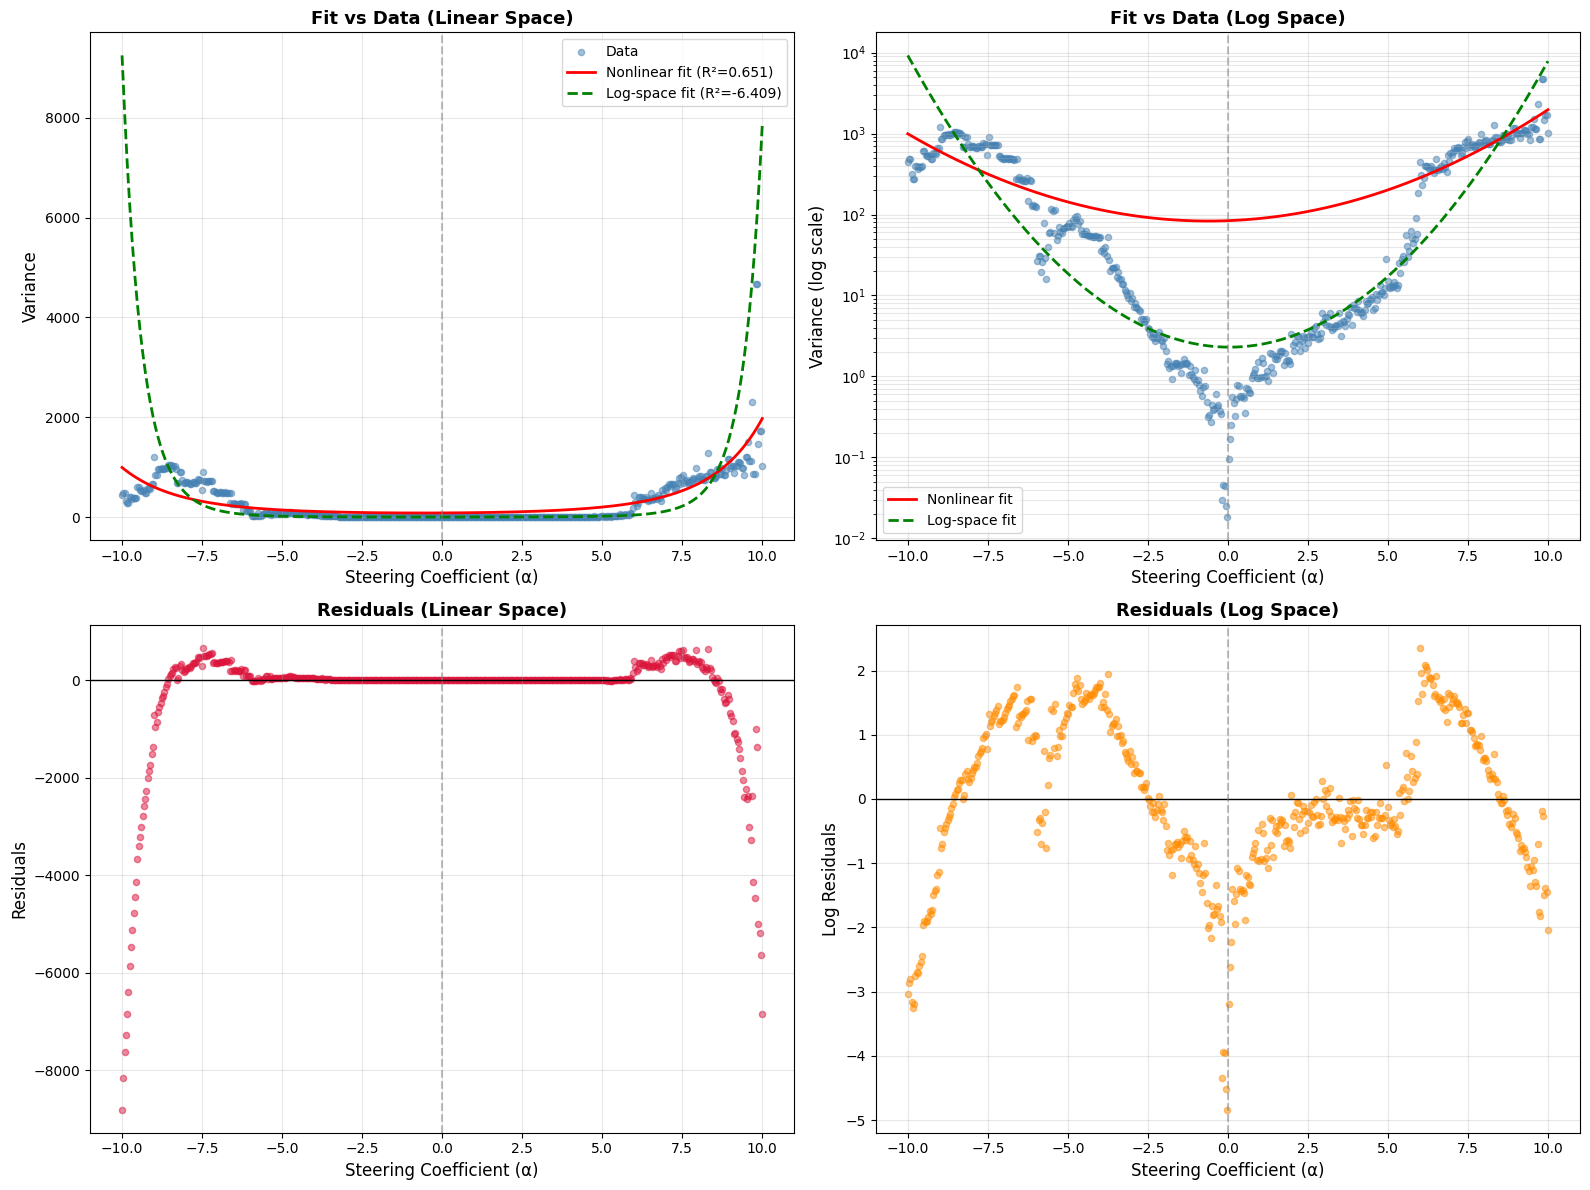

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# ============================================================================
# Panel 1: Linear space
# ============================================================================
ax = axes[0, 0]
ax.scatter(alpha, var, alpha=0.5, s=20, color='steelblue', label='Data')
if fit_success_nonlinear:
    ax.plot(alpha, var_pred, 'r-', linewidth=2, label=f'Nonlinear fit (R²={r2_linear:.3f})')
ax.plot(alpha, var_pred_log, 'g--', linewidth=2, label=f'Log-space fit (R²={r2_linear_from_log:.3f})')
ax.axvline(0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Steering Coefficient (α)', fontsize=12)
ax.set_ylabel('Variance', fontsize=12)
ax.set_title('Fit vs Data (Linear Space)', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# ============================================================================
# Panel 2: Log space
# ============================================================================
ax = axes[0, 1]
ax.scatter(alpha, var, alpha=0.5, s=20, color='steelblue')
if fit_success_nonlinear:
    ax.plot(alpha, var_pred, 'r-', linewidth=2, label='Nonlinear fit')
ax.plot(alpha, var_pred_log, 'g--', linewidth=2, label='Log-space fit')
ax.set_yscale('log')
ax.axvline(0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Steering Coefficient (α)', fontsize=12)
ax.set_ylabel('Variance (log scale)', fontsize=12)
ax.set_title('Fit vs Data (Log Space)', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, which='both')

# ============================================================================
# Panel 3: Residuals (linear fit)
# ============================================================================
ax = axes[1, 0]
residuals_linear = var - var_pred_log
ax.scatter(alpha, residuals_linear, alpha=0.5, s=20, color='crimson')
ax.axhline(0, color='black', linestyle='-', linewidth=1)
ax.axvline(0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Steering Coefficient (α)', fontsize=12)
ax.set_ylabel('Residuals', fontsize=12)
ax.set_title('Residuals (Linear Space)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

# ============================================================================
# Panel 4: Residuals (log fit)
# ============================================================================
ax = axes[1, 1]
ax.scatter(alpha, residuals_log, alpha=0.5, s=20, color='darkorange')
ax.axhline(0, color='black', linestyle='-', linewidth=1)
ax.axvline(0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Steering Coefficient (α)', fontsize=12)
ax.set_ylabel('Log Residuals', fontsize=12)
ax.set_title('Residuals (Log Space)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Interpretation: What Does k Tell Us?

The curvature parameter k measures how fast variance grows with α².

**Physical interpretation:**
- k is related to the **Gaussian curvature** of the manifold
- Larger k → tighter manifold → faster exponential departure
- k is in units of (variance units) / α²

**For this model:**
- If k ≈ 0.01, then at α=5: exp(0.01 × 25) = exp(0.25) ≈ 1.28× baseline variance
- At α=10: exp(0.01 × 100) = exp(1.0) ≈ 2.7× baseline variance

**Comparison to QM scan:**
- If sun and QM have similar k → same underlying geometry
- If different k → content affects manifold curvature

## Extract KALM Boundaries from Fit

Use the fitted model to predict where variance crosses a threshold.

In [6]:
# Define KALM threshold (e.g., 2× baseline variance)
baseline_var = np.exp(c_plus_logA)  # Variance at α=0
kalm_threshold = 2 * baseline_var

# Solve for α where variance = threshold
# variance(α) = exp(k·α² + b·α + c_plus_logA) = kalm_threshold
# k·α² + b·α + c_plus_logA = log(kalm_threshold)
# k·α² + b·α + (c_plus_logA - log(kalm_threshold)) = 0

# Quadratic formula: α = (-b ± sqrt(b² - 4ac)) / 2a
a_coeff = k_log
b_coeff = b_log
c_coeff = c_plus_logA - np.log(kalm_threshold)

discriminant = b_coeff**2 - 4*a_coeff*c_coeff

if discriminant >= 0 and a_coeff > 0:
    alpha_left = (-b_coeff - np.sqrt(discriminant)) / (2*a_coeff)
    alpha_right = (-b_coeff + np.sqrt(discriminant)) / (2*a_coeff)
    
    print(f"\nKALM region (variance < {kalm_threshold:.1f}):")
    print(f"  α ∈ [{alpha_left:.2f}, {alpha_right:.2f}]")
    print(f"  Width: {alpha_right - alpha_left:.2f} α units")
    print(f"  Center: {(alpha_left + alpha_right)/2:.2f}")
    
    if abs((alpha_left + alpha_right)/2) < 0.5:
        print(f"  → KALM region is approximately symmetric")
    else:
        print(f"  → KALM region is shifted (asymmetric)")
else:
    print("\nCannot compute KALM boundaries (discriminant negative or k < 0)")


KALM region (variance < 4.6):
  α ∈ [-2.85, 2.95]
  Width: 5.81 α units
  Center: 0.05
  → KALM region is approximately symmetric


## Summary

**Key findings:**
1. Fitted curvature parameter k quantifies manifold geometry
2. R² and p-values tell us about fit quality and significance
3. KALM boundaries can be predicted from the fitted model
4. Comparing k across datasets (QM vs sun) tests universality

**Next step:** Load QM scan data and compare k values!